# Quickstart

In [1]:
%load_ext autoreload
%autoreload 2

Let's start by download an image that we will use in this notebook

In [2]:
!wget -O test_img.jpg https://pbs.twimg.com/profile_images/3685873778/c22e05a5c956d285e596763e0184e59b.jpeg

--2021-11-08 12:17:20--  https://pbs.twimg.com/profile_images/3685873778/c22e05a5c956d285e596763e0184e59b.jpeg
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.233.50, 2606:2800:134:fa2:1627:1fe:edb:1665
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.233.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7538 (7.4K) [image/jpeg]
Saving to: ‘test_img.jpg’

test_img.jpg        100%[===================>]   7.36K  --.-KB/s    in 0s      

2021-11-08 12:17:20 (105 MB/s) - ‘test_img.jpg’ saved [7538/7538]



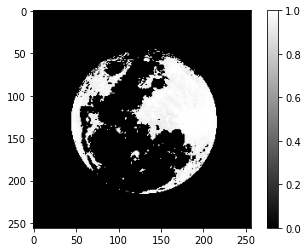

In [3]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("test_img.jpg")[...,0].astype(float)/255.
img = img*(img>0.9)
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

# Heat equation

As an example, we will simulate the heat equation. 

$$
\frac{\partial}{\partial t}u = \nabla^2 u
$$

**NOTE** We don't enforce specific boundary conditions here: they are not yet implemented; currently, boundary conditions are implicitly defined by padding for convolutive operators in Finite Differences (which are padded with zeros), and periodic BC for Fourier discretizations. 
This is not suitable for proper integration of the heat equation, but works whenever we use some absorbing layer at the boundary: that is the majority of situations for acoustics. Clearly, a more suitable handling of generic boundary conditions would be a great addition to the package.

<br/>

We first define the domain where fields are defined. Then, the discretization family that will represent the inputs to the operator, in this case we use Finite Differences

In [4]:
from jaxdf.geometry import Domain
from jaxdf import operators as jops
from jaxdf.core import operator, Field
from jaxdf.discretization import RealFiniteDifferences, RealFourierSeries

from jax import numpy as jnp
import jax

# Setting domain
domain = Domain(N=(256, 256), dx=(1., 1.))

# Initialize discretizations
discr = RealFiniteDifferences(domain, accuracy=2)

# Initialize parameters
u_params, u = discr.empty_field(name='u')

# Define initial conditions
u0 = u_params.at[...,0].set(img)

We can now write the right hand side of the heat equation, using operators imported from `jaxdf.operators`. In this case, it is as trivial as importing the laplacian

In [38]:
def heat_rhs(u):
    return jops.laplacian(u)

We now make this abstract operator concrete, by first wrapping it around an `operator()` decorator, and then calling it with the `u` defined over our Finite Differences discretization.

This automatically generates an intermediate representation, where each operator has been replaced by its corresponding numerical operation, according to the input discretization. Note that the parameters of the operator, in this case the kernel for the laplacian, are treated explicitly

In [39]:
RHS = operator()(heat_rhs)(u=u)
print(RHS)

DiscretizedOperator :: [RealFourierSeries], ['_k5'] 

 Input fields: ('u',)

Globals: Shared: {'k_vec': [DeviceArray([0.        , 0.02454369, 0.04908739, 0.07363108, 0.09817477,
             0.12271847, 0.14726216, 0.17180586, 0.19634955, 0.22089323,
             0.24543694, 0.26998064, 0.2945243 , 0.319068  , 0.34361172,
             0.3681554 , 0.3926991 , 0.4172428 , 0.44178647, 0.46633017,
             0.49087387, 0.5154176 , 0.5399613 , 0.5645049 , 0.5890486 ,
             0.6135923 , 0.638136  , 0.66267973, 0.68722343, 0.7117671 ,
             0.7363108 , 0.7608545 , 0.7853982 , 0.8099419 , 0.8344856 ,
             0.8590293 , 0.88357294, 0.90811664, 0.93266034, 0.95720404,
             0.98174775, 1.0062914 , 1.0308352 , 1.0553788 , 1.0799226 ,
             1.1044662 , 1.1290098 , 1.1535536 , 1.1780972 , 1.202641  ,
             1.2271847 , 1.2517284 , 1.276272  , 1.3008157 , 1.3253595 ,
             1.3499031 , 1.3744469 , 1.3989905 , 1.4235342 , 1.4480779 ,
             1.4726

This means that we can (and indeed, we must) collect those parameters into a dictionary and use it as an auxiliary input

In [40]:
gp = RHS.get_global_params()
print(gp)

{'shared': {'k_vec': [DeviceArray([0.        , 0.02454369, 0.04908739, 0.07363108, 0.09817477,
             0.12271847, 0.14726216, 0.17180586, 0.19634955, 0.22089323,
             0.24543694, 0.26998064, 0.2945243 , 0.319068  , 0.34361172,
             0.3681554 , 0.3926991 , 0.4172428 , 0.44178647, 0.46633017,
             0.49087387, 0.5154176 , 0.5399613 , 0.5645049 , 0.5890486 ,
             0.6135923 , 0.638136  , 0.66267973, 0.68722343, 0.7117671 ,
             0.7363108 , 0.7608545 , 0.7853982 , 0.8099419 , 0.8344856 ,
             0.8590293 , 0.88357294, 0.90811664, 0.93266034, 0.95720404,
             0.98174775, 1.0062914 , 1.0308352 , 1.0553788 , 1.0799226 ,
             1.1044662 , 1.1290098 , 1.1535536 , 1.1780972 , 1.202641  ,
             1.2271847 , 1.2517284 , 1.276272  , 1.3008157 , 1.3253595 ,
             1.3499031 , 1.3744469 , 1.3989905 , 1.4235342 , 1.4480779 ,
             1.4726216 , 1.4971653 , 1.521709  , 1.5462527 , 1.5707964 ,
             1.59534   , 1.61

Lastly, let's compile the numerical function `num_op` that evaluates the operator over a collocation grid

In [41]:
num_op = RHS.get_field_on_grid(0)

We can now call and evaluate the operator, by calling it with the global parameters `gp` and field parameters `u0`. This is a pure function that can be manipulated using JAX program transformations, such as `jit`

In [42]:
y = num_op(gp, {'u': u0})

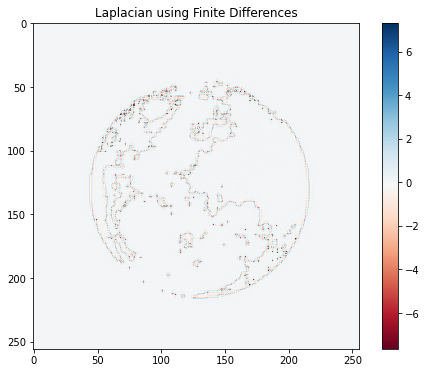

In [43]:
plt.figure(figsize=(8,6))
plt.imshow(y, cmap='RdBu')
plt.title("Laplacian using Finite Differences")
plt.colorbar()

## Change discretization

Suppose we now want to use a Fourier Series discretization, rather than Finite Differences. To reuse the previously defined operator, we need to:

1. Define a new field with the new discretization
2. Call the operator
3. Extract the parameters and numerical function

In [44]:
# New Field
discr = RealFourierSeries(domain)
u_params, u = discr.empty_field(name='u')
u0 = u_params.at[...,0].set(img)

# Compile operator
RHS = operator()(heat_rhs)(u=u)

# Get parameters and pure function
gp = RHS.get_global_params()
num_op = RHS.get_field_on_grid(0)

Let's look at the result

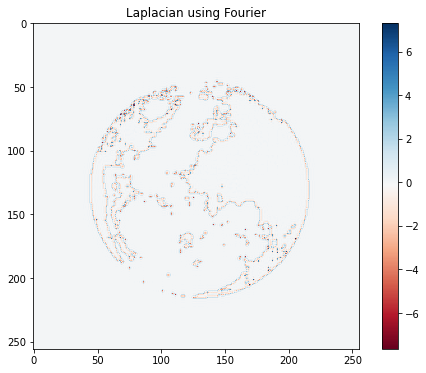

In [45]:
y = num_op(gp, {'u': u0})

plt.figure(figsize=(8,6))
plt.imshow(y, cmap='RdBu')
plt.title("Laplacian using Fourier")
plt.colorbar()

## Euler integration

Let's now integrate the heat equation, using a simple euler integrator. 

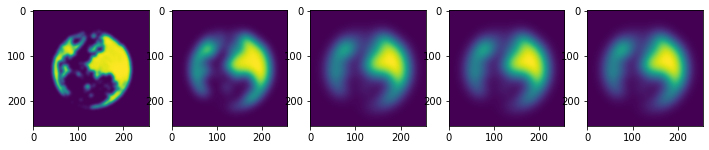

In [46]:
from jaxdf.ode import euler_integration

# Wrap function for integrator
@jax.jit
def f(u_params, t):
    y = num_op(gp, {'u': u_params})
    return y

dt = 0.1
output_steps = jnp.arange(0,1001,50)
    
# Integrate
snapshots = euler_integration(f, u0, dt, output_steps)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(12,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*10])

Let's wrap it all up into a constructor. This funcion accepts a discretization, such that by changing the input we can construct different numerical simulators of the same equation

In [47]:
def make_simulator(
    discretization
):
    # Simulation parameters
    dt = 0.1
    output_steps = jnp.arange(0,1001,50)

    # Initialize parameters
    u_params, u = discretization.empty_field(name='u')
    
    # Discretize the operator
    RHS = operator()(heat_rhs)(u=u)
    gp = RHS.get_global_params()
    func_rhs = RHS.get_field_on_grid(0)
    
    def f(u_params, t):
        y = func_rhs(gp, {'u': u_params})
        return y
    
    @jax.jit
    def simulate(u0):
        return euler_integration(f, u0, dt, output_steps)
    
    return u_params, simulate

In [48]:
params, simulate = make_simulator(RealFiniteDifferences(domain, accuracy=2))
params = u0

In [49]:
snapshots = simulate(u0)

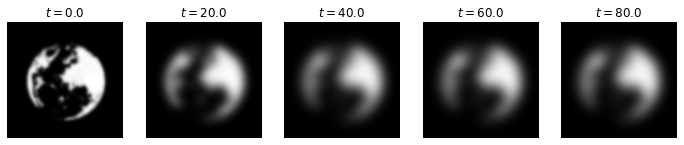

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(12,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*10], vmin=0, vmax=1., cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")

### Timings

Heat equation for 1000 steps using 2nd order accurate Finite Differences, on a 256x256 domain

In [24]:
%%timeit
snapshots = simulate(params).block_until_ready()

83.5 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
params, simulate = make_simulator(RealFourierSeries(domain))
params = u0
snapshots = simulate(params)

Heat equation for 1000 steps using Fourier spectral methods, on a 256x256 domain

In [26]:
%%timeit
snapshots = simulate(params).block_until_ready()

46.7 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## More complex operators

We can of course construct more complex operators than the heat equation, using composition

In [28]:
NonLin = jops.elementwise(lambda x: jnp.abs(x)*jnp.sin(2*jnp.pi*(x+0.25)))
Treshold = jops.elementwise(lambda x: jnp.where(x>0, x, 0.))

def heat_rhs(u):
    L = jops.laplacian(u)
    return L + 0.01*NonLin(u)

In [29]:
params, simulate = make_simulator(RealFourierSeries(domain))
params = u0

In [30]:
snapshots = simulate(params)

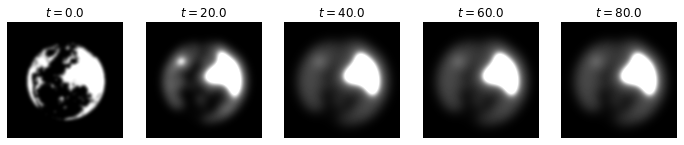

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(12,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*10], vmin=0, vmax=1., cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")